# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
from dqn_agent import Agent
import torch
import json
import os.path
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)
print('States have shape:', state.shape)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37
States have shape: (37,)


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Run an episode given the specified agent

In [7]:
def run_episode(train, agent, eps=0):
    """
    Run an episode
    
    Params
    ======
        train (boolean) : specifies if the agent should be trained during the episode
        agent (Agent) : the agent to use
        eps (float): epsilon for the epsilon greedy action selection
    """
    env_info = env.reset(train_mode=train)[brain_name] # reset the environment
    state = env_info.vector_observations[0]  # the state of the environment
    score = 0
    while  True:
        action = agent.act(state, eps)                 # get the action from the agent
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        agent.step(state, action, reward, next_state, done)

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:
            break 
        if train == False :
            time.sleep(0.02) # on my hardware, it goes to fast too clearly see action changes
    return score

## Train the agent given the specified set of parameters

In [8]:
def dqn(parameters, n_episodes=10, save=False):
    
    """Deep Q-Learning.
    
    Params
    ======
        n_episodas (int): maximum number of training episodes
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    lr =5e-4
    agent = Agent(
        state_size,
        action_size,
        seed=0,
        buffer_size=parameters['buffer_size'],
        batch_size=parameters['batch_size'],
        gamma=parameters['gamma'],
        tau=parameters['tau'],
        lr=lr,
        update_every=parameters['update_every'],
        layers_units=parameters['layers_units']
    )
    eps_end = 0.01
    scores = []                        # list containing scores from each episode
    scores_averaged_previous_100 = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = 1.0                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        score = run_episode(True, agent, eps)    # run the epsiode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, parameters['eps_decay'] *eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        mean_score = np.mean(scores_window)
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            scores_averaged_previous_100.append(mean_score)
    if save :
        torch.save(agent.qnetwork_local.state_dict(), 'model.pth'.format(i_episode))
    return scores, scores_averaged_previous_100



## Hyper parameters tuning 

The Deep Q-Network algorithm alongside the experience replay and fixed Q Targets introduces many parameters we can play on to speed up the convergence and the final score of the trained agent.

Setting the right values for these parameters is not obvious. On the basis of some guidances from the litterature, we propose the following approach to find a good distribution of hyper parameters : We start with the values from the DQN project that worked fine for the Lunar lander OpenAI Gym's LunarLander environment and that are close to the values proposed in the litterature.

Since the training of the agent is time consuming, we chosed the following simple heuristic approach to find a good value for each hyper parameter. For each parameter, we introduce a list of values to test. Among those values, the one we keep is the one that lead to the best average score over the last 100 episodes after 5000 epsiodes of training.

The following parameters are adjusted through our naive sequential heuristic.

- **eps_decay** : The coefficient applied on the *Epsilon* parameter after each epsiode ( balance exploration and exploitation in Epsilon-greedy action selection),
- **buffer_size** : The size of the replay buffer in the context of the *Experience replay*,
- **batch_size** : The size of the batch involved in the Q-learning update enhanced using *Experience replay*,
- **gamma** : The discount factor involved in the rewards expectation,
- **tau** : In the Q targets update from fixed Q target context, defines the weight given to the new parameters for the update.
- **update_every** : defines the update rate of the target from the Fixed Q Targets strategy,
- **layers_units** : The input of our neural network is an heterogeneous representation of the environment (ray based + velocities). Therefore, we kept a fully connected neural network. This parameter is a list that gives the number of neurons of each hidden layers.

In [9]:
# The values to test for each parameter
hyper_parameters = {
        'eps_decay': [0.995, 0.99, 0.999],
        'buffer_size':[int(1e5), int(1e6)],
        'batch_size':[64, 256],
        'gamma':[0.9, 0.99, 0.995],
        'tau':[5e-2, 1e-3, 5e-4],
        'update_every' : [2, 4, 8],
        'layers_units' : [[128, 256, 256, 128], [32, 64, 32], [64, 128, 64],[64, 64], [64, 32, 16, 16]]
    }

# the default value, from DQN projet of the Deep Reinforcement learning course
# applied on Lunar Lander from Open AI Gym
default = {
        'eps_decay': 0.995,
        'buffer_size':int(1e5),
        'batch_size':64,
        'gamma':0.99,
        'tau':1e-3, 
        'update_every' : 4,
        'layers_units' : [64, 64]
    }

def to_name(parameters) :
    """
    built a user friendly string that describes a particular experiment,
    specified by a value distribution for parameters
    """
    return ' '.join('{}={}'.format(name, str(value)) for name, value in parameters.items())


## Save partial result
Our hyper parameters tuning heuristic implies to training 21 times the agent. Since this is time consuming, we save the result after each training to be able to stop and resume our computations when we want without loosing what has already been computed. 

In [10]:
# load what has already been computed
if os.path.exists('hyper_parameters_tuning.json'):
    with open('hyper_parameters_tuning.json') as json_file:
        results = json.load(json_file)
else :
    results = {}


## Evaluate each value for each hyper parameter
Train the agent for 5000 iterations and save a json that gives for each experiment the average value over the last 100 iterations, each 100 iterations

In [11]:
# find sequentially the "best" value for each parameters after 1000 episodes. 
# When a parameter is choosen, the others take values from the dqn project

for name, parameter in hyper_parameters.items() :
    
    for value in parameter :
        key = '{}_{}'.format(name, str(value))
        if not key in results :
            print("\n\nTuning parameter {}, value = {}".format(name, value))
            parameters = default.copy()
            parameters[name] = value
            scores, scores_averaged_previous_100 = dqn(parameters, 5000)
            results[key] = scores_averaged_previous_100
            with open('hyper_parameters_tuning.json', 'w') as fp:
                json.dump(results, fp)       
        else :
            print("\nparameter {}, value = {} already tuned".format(name, value))
with open('hyper_parameters_tuning.json', 'w') as fp:
    json.dump(results, fp)       


parameter eps_decay, value = 0.995 already tuned

parameter eps_decay, value = 0.99 already tuned

parameter eps_decay, value = 0.999 already tuned

parameter buffer_size, value = 100000 already tuned

parameter buffer_size, value = 1000000 already tuned

parameter batch_size, value = 64 already tuned

parameter batch_size, value = 256 already tuned

parameter gamma, value = 0.9 already tuned

parameter gamma, value = 0.99 already tuned

parameter gamma, value = 0.995 already tuned

parameter tau, value = 0.05 already tuned

parameter tau, value = 0.001 already tuned

parameter tau, value = 0.0005 already tuned

parameter update_every, value = 2 already tuned

parameter update_every, value = 4 already tuned

parameter update_every, value = 8 already tuned

parameter layers_units, value = [128, 256, 256, 128] already tuned

parameter layers_units, value = [32, 64, 32] already tuned

parameter layers_units, value = [64, 128, 64] already tuned

parameter layers_units, value = [64, 64] al

Given the results plotted in Notebook **Hyper parameters tuning curves**, we choosed the following distribution of hyper parameters. Note that some values are identical to those of the Lunar Lander project while other changed :  

In [12]:
chosen_parameters = {
        'eps_decay': 0.99,
        'buffer_size':int(1e5),
        'batch_size':64,
        'gamma':0.99,
        'tau':1e-3, 
        'update_every' : 8,
        'layers_units' : [64, 32, 16, 16]
    }

## Train the model with the chosen parameters

In [13]:
if not os.path.exists('model.pth'): 
    # train only if it has not been done:
    scores, scores_averaged_previous_100 = dqn(chosen_parameters, 5000, True)
    results = {'scores' : scores, 'scores_averaged_previous_100' : scores_averaged_previous_100 }
    with open('final.json', 'w') as fp:
        json.dump(results, fp)       

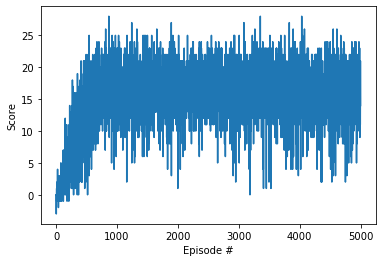

In [14]:
# load what has already been computed
if os.path.exists('final.json'):
    with open('final.json') as json_file:
        results = json.load(json_file)
        
# plot the scores
scores = results['scores']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Let's see how our agent behave !

In [17]:
agent = Agent(
        state_size,
        action_size,
        seed=0,
        buffer_size=chosen_parameters['buffer_size'],
        batch_size=chosen_parameters['batch_size'],
        gamma=chosen_parameters['gamma'],
        tau=chosen_parameters['tau'],
        lr=5e-4,
        update_every=chosen_parameters['update_every'],
        layers_units=chosen_parameters['layers_units']
    )
agent.qnetwork_local.load_state_dict(torch.load('model.pth'))
run_episode(False, agent)

21.0

In [18]:
env.close()